In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import sys
from pathlib import Path, PurePath
sys.path.append("..")
# For quicksort
sys.setrecursionlimit(int(1e7))

from src.linear_sorting_algorithms import radixsort
from src.quadratic_sorting_algorithms import bubble_sort, insertion_sort
from src.subquad_sorting_algorithms import quicksort, mergesort
from src.combined_sorting_algorithm import mergesort_combined

from src.utility import time_sorting_algorithms, ArrayGenerator

os.getcwd()
import matplotlib.pyplot as plt




In [3]:
if Path('../data').exists():
    data_directory = PurePath("../data")
    print(data_directory)

..\data


In [4]:
array_gen = ArrayGenerator(seed=None)

# N for 2-base generator, N^2
N = 1000
cols = {"Ascending" : np.single, "Descending" : np.single, "Random" : np.single, "Structured" : np.single, "Integers" :np.int32}

test_data = dict()


for i in range(2, N+1, 1):
    # Inverse of 2^N to create small steps
    n = i
    i = math.log2(i)
    
    data = np.array([array_gen.sorted_array(i),
            array_gen.reversed_array(i),
            array_gen.random_array(i),
            array_gen.structured_array(i),
            array_gen.integer_array(i)
           ])
    test_data[n] = pd.DataFrame(columns=cols.keys(), data=data.T).astype(cols)

In [5]:
len(test_data)

999

In [6]:
list_of_algorithms = [insertion_sort, mergesort]

df_results = pd.DataFrame(columns=["Algorithm", "N", "TypeArray", "Time"])

for N, Array in test_data.items():
    for TypeArray in cols.keys():
        
        for algorithm, times in time_sorting_algorithms(
            functions=list_of_algorithms, 
            array=Array[TypeArray].to_numpy(), 
            iters=5, 
            verbose=False
        ).items():
            
            for time in times:
                
                df_results = df_results.append(
                    {
                    "Algorithm": algorithm, "N": N, "TypeArray": TypeArray, "Time": time
                    }, 
                    ignore_index=True
                ) 
    if N % 100 == 0:
        print(f"Timed and gather result for up to {N} element arrays")

Timed and gather result for up to 100 element arrays
Timed and gather result for up to 200 element arrays
Timed and gather result for up to 300 element arrays
Timed and gather result for up to 400 element arrays
Timed and gather result for up to 500 element arrays
Timed and gather result for up to 600 element arrays
Timed and gather result for up to 700 element arrays
Timed and gather result for up to 800 element arrays
Timed and gather result for up to 900 element arrays
Timed and gather result for up to 1000 element arrays


In [7]:
df_results["time/n(us)"] = ((df_results['Time']/df_results['N'])*1e6).to_numpy(dtype='float32')

In [8]:
df_results.dtypes

Algorithm      object
N              object
TypeArray      object
Time          float64
time/n(us)    float32
dtype: object

In [9]:
df_results.N = df_results.N.to_numpy(dtype='int32')

In [10]:
df_results.head()

,Algorithm,N,TypeArray,Time,time/n(us)
0,insertion_sort,2,Ascending,4.906771e-01,245338.546875
1,insertion_sort,2,Ascending,2.100000e-06,1.050000
2,insertion_sort,2,Ascending,5.999996e-07,0.300000
3,insertion_sort,2,Ascending,6.000000e-07,0.300000
4,insertion_sort,2,Ascending,5.000002e-07,0.250000


In [11]:
height=100
width=120
IMAGE_SIZE = (width/25.4, height/25.4)

plt.rcParams['axes.titlesize'] = 9
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

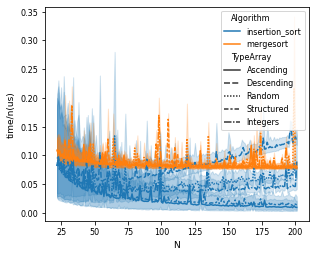

In [12]:
plt.figure(figsize=IMAGE_SIZE)
sns.lineplot(
    data=df_results.iloc[1000:10000], 
    x="N", y="time/n(us)", hue="Algorithm", style="TypeArray")
plt.savefig("optimizing ")

In [13]:
mean_df = df_results.groupby(['Algorithm','N']).mean()
mean_df.index.get_level_values('N')

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
             991,  992,  993,  994,  995,  996,  997,  998,  999, 1000],
           dtype='int64', name='N', length=1998)

In [15]:
mean_df = mean_df[(mean_df.index.get_level_values('N') > 20) & (mean_df.index.get_level_values('N') < 500)]

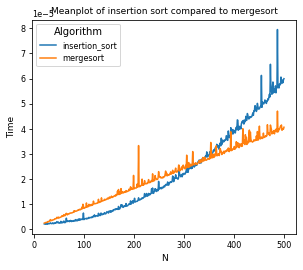

In [18]:
plt.figure(figsize=IMAGE_SIZE)
sns.lineplot(
    data=mean_df, 
    x="N", y="Time", hue="Algorithm")
plt.title("Meanplot of insertion sort compared to mergesort")
plt.savefig(f"optimizing_combined_threshold.png", bbox_inches='tight', transparent=True)
plt.show()

In [58]:
delta_series = (mean_df.loc['mergesort', '3':].Time - mean_df.loc['insertion_sort', '3':].Time)
delta_series

N
21      6.160000e-07
22      6.120000e-07
23      8.080000e-07
24      8.120000e-07
25      7.680000e-07
            ...     
996    -1.558000e-04
997    -1.553960e-04
998    -1.579080e-04
999    -1.564960e-04
1000   -1.590760e-04
Name: Time, Length: 980, dtype: float64

In [65]:
delta_series.idxmax()

142

In [68]:
np.amax(delta_series)

6.559999997080013e-06

In [72]:
delta_series.sort_values(ascending=False).head(30)

N
142    0.000007
170    0.000007
175    0.000006
166    0.000006
196    0.000006
159    0.000006
202    0.000006
176    0.000006
168    0.000006
193    0.000006
188    0.000006
153    0.000006
200    0.000006
174    0.000006
192    0.000006
165    0.000006
183    0.000006
163    0.000006
164    0.000006
151    0.000006
141    0.000006
155    0.000006
160    0.000006
167    0.000006
145    0.000006
209    0.000006
184    0.000006
177    0.000006
156    0.000006
152    0.000006
Name: Time, dtype: float64

## Using $\Delta$ we have found the optimal threshold
**The results are averaged over all the different types of array, including best case and worst case for insertion sort**

We will use 142 as the threshold for using insertion sort

**note:** all functions have been Just in time compiled by numba jit function